# Rede Hidrometeorológica Nacional

## Espacialização de dados de precipitação na bacia hidrográfica

Trabalhando com os dados da Rede Hidrometeorológica Nacional, da Agência Nacional de Águas (ANA).

## Importando bibliotecas

In [1]:
import requests
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import seaborn as sns
from shapely import geometry, ops
import fiona
import geopandas as gpd
from datetime import datetime, timedelta
from calendar import monthrange

In [2]:
# # Atualizar o Google Download
# !pip install --upgrade --no-cache-dir gdown

Baixar o arquivo com todos os shapefiles criados no notebook Aula 09c

* bacia
* hidro
* pluvio_sel
* exuto

https://drive.google.com/file/d/1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI/view?usp=sharing

In [3]:
!gdown 1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI

Downloading...
From: https://drive.google.com/uc?id=1ng26-3zXXmMUmhqA_DJueTb7nH4VgNKI
To: /content/shapefiles_pluvio_sel.zip
100% 1.31M/1.31M [00:00<00:00, 66.0MB/s]


In [4]:
!unzip shapefiles_pluvio_sel.zip

Archive:  shapefiles_pluvio_sel.zip
   creating: content/shapefiles/
   creating: content/shapefiles/exuto/
  inflating: content/shapefiles/exuto/exuto.dbf  
  inflating: content/shapefiles/exuto/exuto.prj  
  inflating: content/shapefiles/exuto/exuto.shp  
  inflating: content/shapefiles/exuto/exuto.shx  
 extracting: content/shapefiles/exuto/exuto.cpg  
   creating: content/shapefiles/pluvio/
  inflating: content/shapefiles/pluvio/pluvio_sel.prj  
  inflating: content/shapefiles/pluvio/pluvio_sel.dbf  
  inflating: content/shapefiles/pluvio/pluvio_sel.shx  
  inflating: content/shapefiles/pluvio/pluvio_sel.shp  
 extracting: content/shapefiles/pluvio/pluvio_sel.cpg  
   creating: content/shapefiles/bacia/
  inflating: content/shapefiles/bacia/bacia.shx  
 extracting: content/shapefiles/bacia/bacia.cpg  
  inflating: content/shapefiles/bacia/bacia.dbf  
  inflating: content/shapefiles/bacia/bacia.prj  
  inflating: content/shapefiles/bacia/bacia.shp  
   creating: content/shapefiles/h

In [5]:
exuto = gpd.read_file('content/shapefiles/exuto/exuto.shp')
pluvio_sel = gpd.read_file('content/shapefiles/pluvio/pluvio_sel.shp')
bacia = gpd.read_file('content/shapefiles/bacia/bacia.shp')
hidro = gpd.read_file('content/shapefiles/hidro/hidro.shp')

## Fazer o download dos dados das estações

* Restaram 8 pluviômetros

Após o tratamento do CSV (notebook da Aula 09b) e verificação das falhas (notebook da Aula 09c)

Copiar e colar o arquivo CSV no seu Google Drive, compartilhar com 'qualquer pessoa com o link' e copir o link:

Importando os dados de precipitação

* prec_8_pluv.csv - https://drive.google.com/file/d/1P61STEi1w6cHqJMZOufQHgvODXb2s6q8/view?usp=sharing

In [6]:
# Extrair do link o código no meio das barras e fazer o download no servidor do google
!gdown 1P61STEi1w6cHqJMZOufQHgvODXb2s6q8

Downloading...
From: https://drive.google.com/uc?id=1P61STEi1w6cHqJMZOufQHgvODXb2s6q8
To: /content/prec_8_pluv_sel.csv
100% 493k/493k [00:00<00:00, 30.7MB/s]


In [7]:
# leitura dos dados com pandas
df_pluv = pd.read_csv('prec_8_pluv_sel.csv')

print(len(df_pluv))

11323


In [8]:
df_pluv['data'] = pd.to_datetime(df_pluv["data"])
df_pluv = df_pluv.set_index('data')

In [9]:
# Acumula dados anuais
df_prec_anual  = df_pluv.resample("Y").sum()

In [10]:
df_prec_anual

,1068000,966000,963001,867001,765000,770000,668000,567001
data,,,,,,,,
1980-12-31,1911.1,2373.5,2314.7,1478.5,2320.6,1895.1,2683.6,2327.7
1981-12-31,1892.7,1690.0,2130.1,2496.6,2600.8,5128.5,2457.8,2731.3
1982-12-31,2000.7,2072.3,3025.7,1762.2,2615.4,5123.4,2472.1,2840.4
1983-12-31,1707.6,1370.6,1242.4,1160.8,1982.0,2860.1,2149.4,2210.3
1984-12-31,2025.2,1974.1,1733.5,1932.1,2708.1,4421.9,2170.7,2719.7
1985-12-31,2322.2,1476.3,2315.0,3623.0,2967.9,2676.3,3254.6,2571.6
1986-12-31,1481.2,2079.7,2053.2,2244.8,2466.9,2489.8,2635.2,2704.6
1987-12-31,1663.4,2478.2,2404.1,1346.5,2064.8,2556.5,2430.6,2488.3
1988-12-31,1801.2,1713.7,2559.3,1362.1,2440.3,2455.4,2479.7,2751.9


<ipython-input-11-cfa9c22acf86>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = df_prec_anual['1068000'].index.year, rotation = 45, fontsize=8)


[]

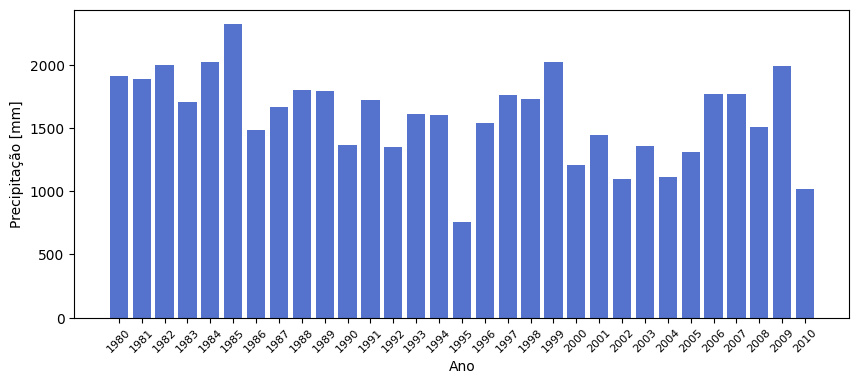

In [11]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=df_prec_anual['1068000'].index, y=df_prec_anual['1068000'], color = "royalblue")
#ax = sns.barplot(x=df_869000_anual.index, y=df_869000_anual["prec(mm)"], color = "green")
#ax = sns.barplot(x=df_1168001_anual.index, y=df_1168001_anual["prec(mm)"], color = "red")
ax.set_xlabel("Ano")
ax.set_ylabel("Precipitação [mm]")
ax.set_xticklabels(labels = df_prec_anual['1068000'].index.year, rotation = 45, fontsize=8)
plt.plot()

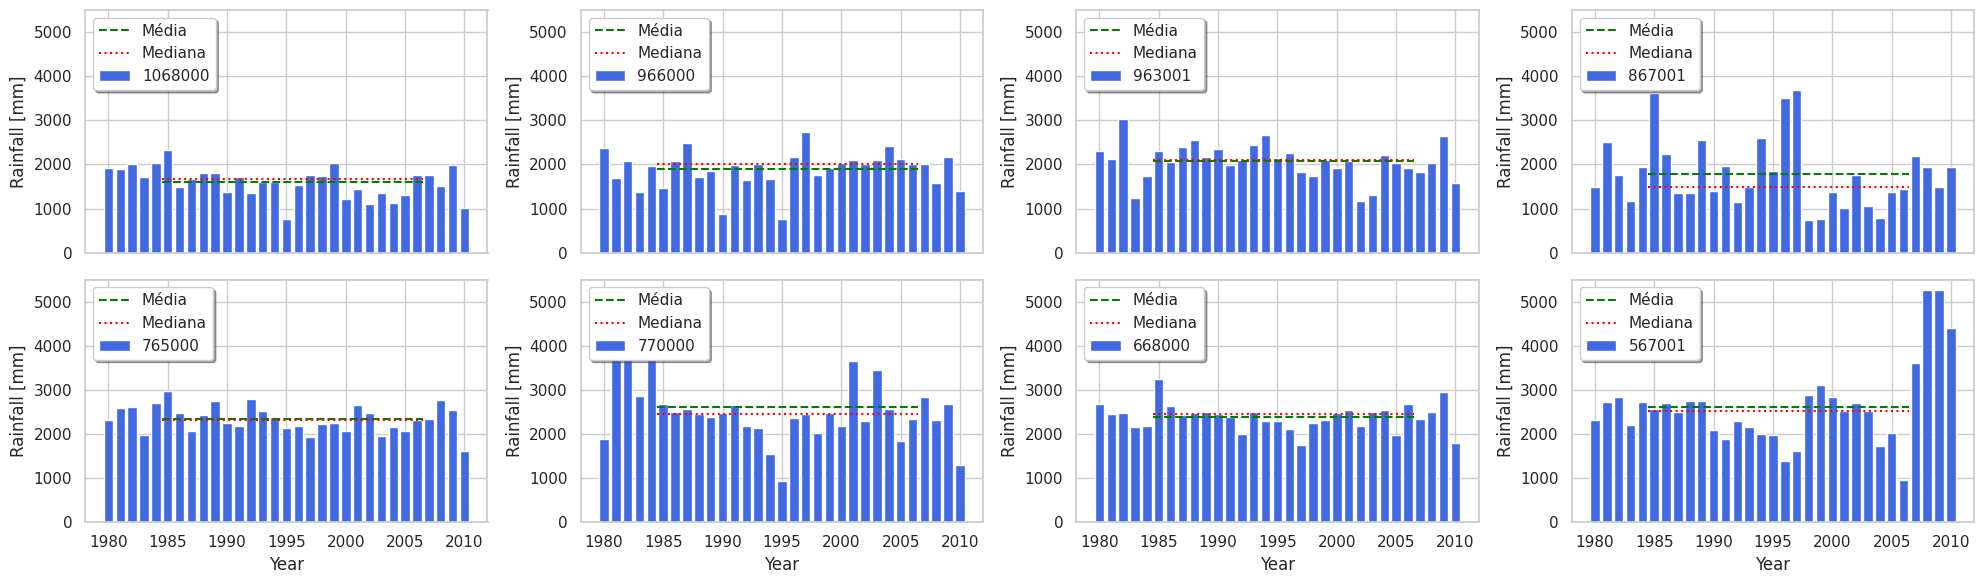

In [12]:
sns.set(style="whitegrid")

fig1, ax = plt.subplots(2,4, figsize = (20,6), tight_layout=True, sharex = True)

for i, (ax, value, name) in enumerate(zip(ax.flatten(), df_prec_anual.values.T, df_prec_anual.columns)):
    #ax.set_xticks(df_prec_anual.index.year)
    #ax.set_xticklabels(labels = df_prec_anual.index.year.values, rotation=60)
    ax.bar(df_prec_anual.index.year, df_prec_anual[name], label=name, color = "royalblue")

    ax.hlines(df_prec_anual[name].mean(), 1984.5, 2006.5, color="green", label="Média", ls = "--")
    ax.hlines(df_prec_anual[name].median(), 1984.5, 2006.5, color="red", label="Mediana", ls = ":")
    if i >3:
        ax.set_xlabel ("Year")
    ax.set_ylabel("Rainfall [mm]")
    ax.set_ylim(0, 5500)
    ax.legend(shadow=True, loc="upper left")

plt.savefig('comparacao_8_pluv.png', dpi = 100, bbox_inches='tight')
plt.show();

In [13]:
df_stats = df_prec_anual.describe().T
df_stats

,count,mean,std,min,25%,50%,75%,max
1068000,31.0,1602.074194,345.408693,755.2,1363.05,1663.4,1798.40,2322.2
966000,31.0,1889.954839,421.574169,763.2,1682.70,2000.1,2106.65,2740.9
963001,31.0,2074.425806,412.022706,1179.6,1873.90,2099.1,2314.85,3025.7
867001,31.0,1787.858065,787.663740,731.3,1354.30,1486.3,2074.10,3690.1
765000,31.0,2345.125806,304.077957,1625.5,2143.45,2320.6,2567.55,2967.9
770000,31.0,2603.800000,932.397721,939.3,2174.35,2455.4,2679.65,5128.5
668000,31.0,2390.180645,303.330522,1752.8,2209.80,2443.5,2504.70,3254.6
567001,31.0,2623.641935,954.192034,959.2,2059.30,2523.1,2791.30,5271.0


In [14]:
pluvio_sel

,CODIGO,lon,lat,name,geometry
0,1068000,-68.5067,-10.6497,1068000,POINT (-68.50670 -10.64970)
1,966000,-66.6117,-9.7556,966000,POINT (-66.61170 -9.75560)
2,963001,-63.1619,-9.2606,963001,POINT (-63.16190 -9.26060)
3,867001,-67.4003,-8.7356,867001,POINT (-67.40030 -8.73560)
4,765000,-66.0583,-7.7156,765000,POINT (-66.05830 -7.71560)
5,770000,-70.0225,-7.4281,770000,POINT (-70.02250 -7.42810)
6,668000,-68.2439,-6.4417,668000,POINT (-68.24390 -6.44170)
7,567001,-67.8569,-5.8936,567001,POINT (-67.85690 -5.89360)


In [15]:
exuto2 = exuto[['CODIGO', 'NOME','LATITUDE', 'LONGITUDE','geometry']]
exuto2

,CODIGO,NOME,LATITUDE,LONGITUDE,geometry
0,13880000,CANUTAMA,-6.5389,-64.3858,POINT (-64.38580 -6.53890)


# Pluviômetros escolhidos para a análise

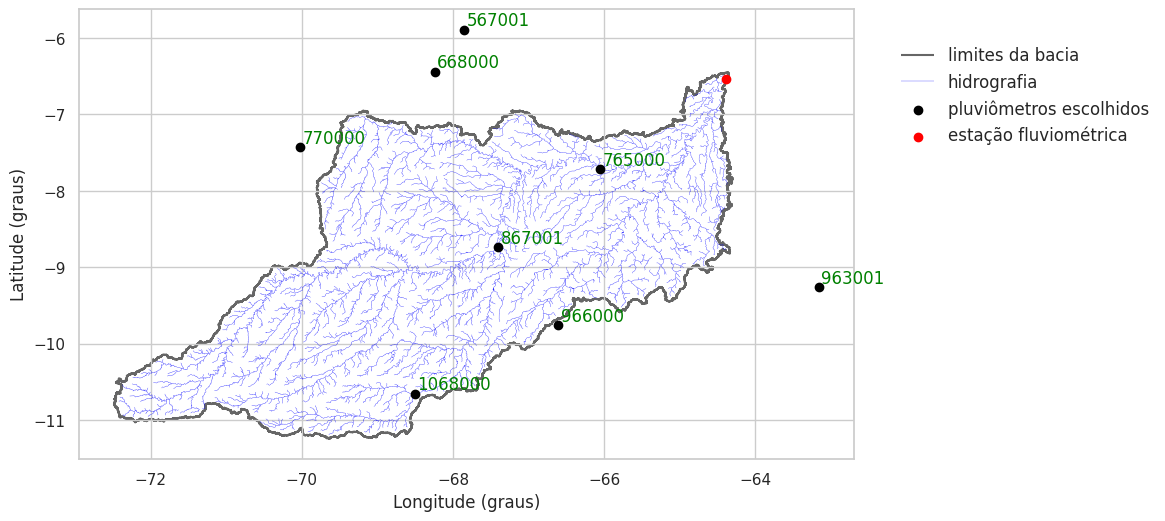

In [16]:
fig, ax = plt.subplots(figsize = (10, 6))

bacia.geometry.boundary.plot(ax = ax, alpha = 0.6, color = None, edgecolor =  "black", label = 'limites da bacia',zorder=0)
hidro.plot(ax=ax,color='blue', linewidth=0.2, label = 'hidrografia',zorder=1)
ax.scatter(pluvio_sel["lon"], pluvio_sel["lat"], color = "black", label = 'pluviômetros escolhidos',zorder=2)
for i, (x,y) in enumerate(zip (pluvio_sel["lon"], pluvio_sel["lat"])):
    label = pluvio_sel["name"][i]
    ax.annotate(label, (x,y), textcoords = "offset points", xytext = (2,3), color = "green")

plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')

ax.scatter(exuto2['LONGITUDE'], exuto2['LATITUDE'], color = "red", label = 'estação fluviométrica',zorder=3)

plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=12)

# Show the plot
plt.savefig('pluviometros_escolhidos.png', dpi = 100, bbox_inches='tight')
#plt.savefig('Mutations_bars_correlation.pdf', dpi = 600, bbox_inches='tight')
plt.show();

## Quantidade de falhas

In [17]:
# Número absoluto de dias com falha
df_pluv.isna().sum()

1068000    462
966000     373
963001     473
867001     522
765000     160
770000     458
668000     435
567001     398
dtype: int64

In [18]:
total_de_dias = len(df_pluv)
total_de_dias

11323

In [19]:
# Número relativo de dias com falha
df_pluv.isna().sum()/total_de_dias

1068000    0.040802
966000     0.032942
963001     0.041773
867001     0.046101
765000     0.014131
770000     0.040449
668000     0.038417
567001     0.035150
dtype: float64

In [ ]:
#pluvio_sel

## Preenchimento das falhas

* Vamos encontrar as estações mais próximas

#### Temos pelo menos uma estação com dado em cada dia?

In [20]:
# vou fazer a média em cada dia e procurar falhas na média diária entre estações:
df_pluv.mean(axis=1).isna().sum()


0

#### Não há falha nas médias por dia!
#### Ou seja, temos pelo menos uma estação com dado de chuva em cada dia!

:)

Se não tivermos você pode procurar outro pluviômetro próximo que tenha dados. Ou pode importar os dados de precipitação da base CABra para preencher as falhas.

# Gráfico Heatmap com as falhas

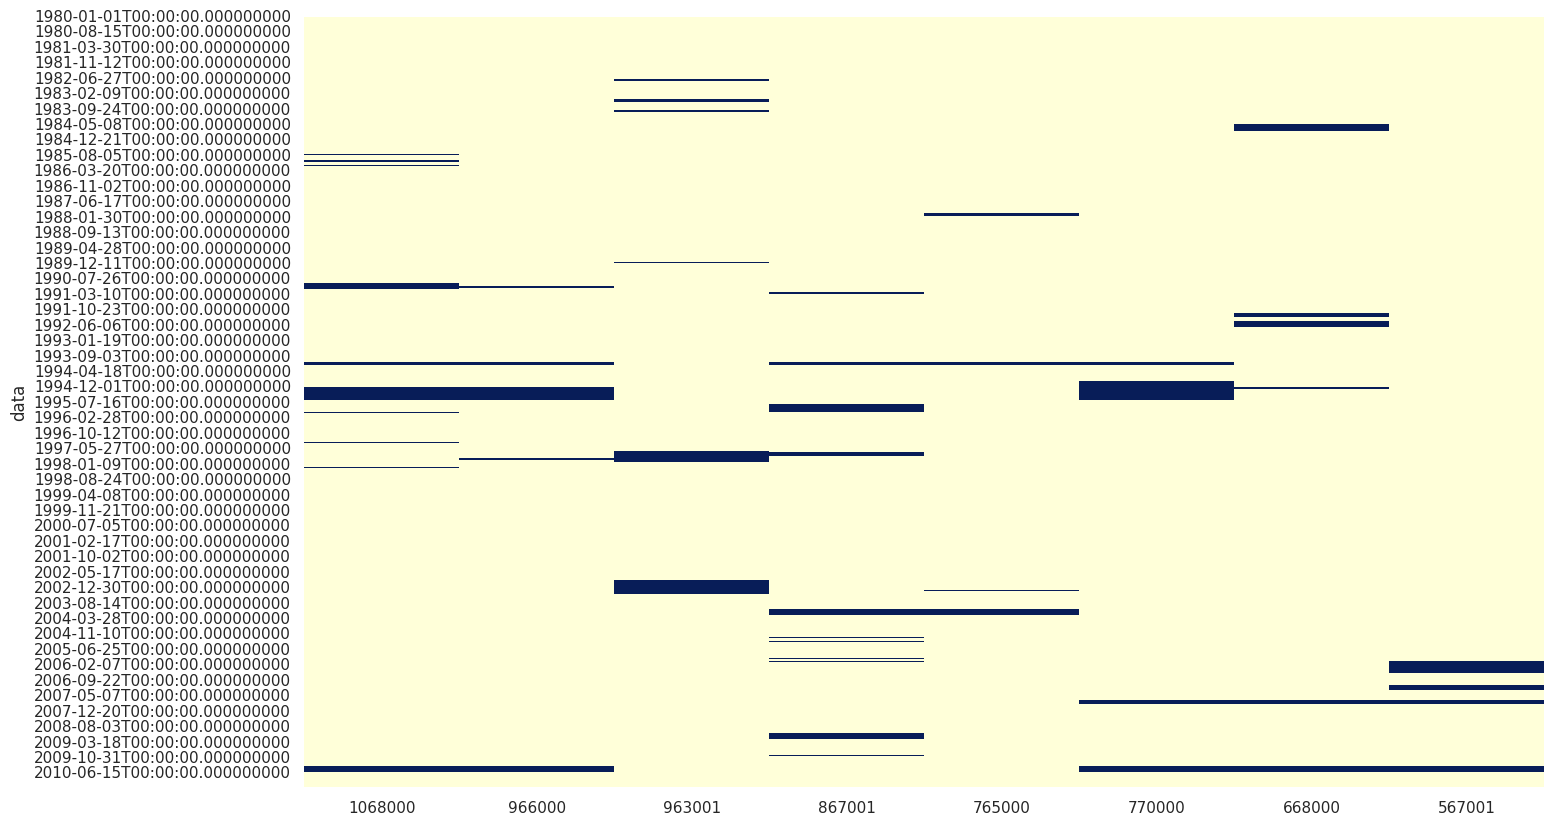

In [21]:
plt.figure(figsize=(16,10))
sns.heatmap(df_pluv.isnull(), cbar=False, cmap="YlGnBu")
plt.show()

In [ ]:
#df_pluv

In [ ]:
#pluvio_sel

## Função para encontrar as estações mais próximas de um pluviômetro

A função `encontra_pluv_proximos()` vai buscar pelas coordenadas qual é a lista de pluviômetros mais próximos de um certo pluviômetro.

No plano euclidiano, seja o ponto $p$ com coordenadas cartesianas ($p_{1}$,$p_{2}$) e seja o ponto $q$ com coordenadas ($q_{1}$,$q_{2}$). Então a distância entre $p$ e $q$ é dada por:

$$
d(p,q) = \sqrt{(p_1-q_1)^2 + (p_2-q_2)^2}
$$

In [22]:
df_lista_pluv = pd.DataFrame(pluvio_sel)
df_lista_pluv

,CODIGO,lon,lat,name,geometry
0,1068000,-68.5067,-10.6497,1068000,POINT (-68.50670 -10.64970)
1,966000,-66.6117,-9.7556,966000,POINT (-66.61170 -9.75560)
2,963001,-63.1619,-9.2606,963001,POINT (-63.16190 -9.26060)
3,867001,-67.4003,-8.7356,867001,POINT (-67.40030 -8.73560)
4,765000,-66.0583,-7.7156,765000,POINT (-66.05830 -7.71560)
5,770000,-70.0225,-7.4281,770000,POINT (-70.02250 -7.42810)
6,668000,-68.2439,-6.4417,668000,POINT (-68.24390 -6.44170)
7,567001,-67.8569,-5.8936,567001,POINT (-67.85690 -5.89360)


In [23]:
def encontra_pluv_proximos(posto,df_lista_pluv):
  # Pluviômetro que estamos trabalhando = atual
  atual = df_lista_pluv.loc[df_lista_pluv['CODIGO'] == posto]

  # Pluviômetros que estão próximos ao atual = possiveis
  possiveis = df_lista_pluv.loc[df_lista_pluv['CODIGO'] != posto]
  possiveis = possiveis.reset_index()

  x = atual['lon'].values
  y = atual['lat'].values
  #print(x,y)

  lista_x = possiveis['lon'].values
  lista_y = possiveis['lat'].values
  #print(lista_x,lista_y)

  d = []
  for i in range(len(possiveis)):
    d.append(np.sqrt((x-lista_x[i])**2+(y-lista_y[i])**2))

  possiveis['distancia'] = np.array(d)
  proximos = possiveis.sort_values(by=['distancia'])
  return proximos['CODIGO'].values

In [24]:
# Testando função que encontra pluviômetros próximos
posto = 966000
encontra_pluv_proximos(posto,df_lista_pluv)

array([ 867001, 1068000,  765000,  963001,  668000,  567001,  770000])

# Preenchendo valores faltantes de uma coluna com outra



In [25]:
#teste
posto = 1068000
mais_proximo = encontra_pluv_proximos(posto,df_lista_pluv)
j=0
print(posto,mais_proximo[j])
df_pluv[str(posto)].fillna(df_pluv[str(mais_proximo[j])])

1068000 966000


data
1980-01-01    20.5
1980-01-02     0.0
1980-01-03     0.0
1980-01-04     0.0
1980-01-05     0.0
              ... 
2010-12-27     0.0
2010-12-28     0.0
2010-12-29     0.0
2010-12-30    10.4
2010-12-31    11.6
Name: 1068000, Length: 11323, dtype: float64

In [26]:
for posto in df_pluv.columns:
  posto = int(posto)
  print(posto)
  mais_proximo = encontra_pluv_proximos(posto,df_lista_pluv)
  print(mais_proximo)
  for j in range(len(mais_proximo)):
    df_pluv[str(posto)] = df_pluv[str(posto)].fillna(df_pluv[str(mais_proximo[j])])

1068000
[966000 867001 770000 765000 668000 567001 963001]
966000
[ 867001 1068000  765000  963001  668000  567001  770000]
963001
[ 765000  966000  867001 1068000  567001  668000  770000]
867001
[ 966000  765000 1068000  668000  567001  770000  963001]
765000
[ 867001  966000  668000  567001  963001 1068000  770000]
770000
[ 668000  567001  867001 1068000  765000  966000  963001]
668000
[ 567001  770000  867001  765000  966000 1068000  963001]
567001
[ 668000  765000  770000  867001  966000 1068000  963001]


In [27]:
df_pluv.isna().sum()

1068000    0
966000     0
963001     0
867001     0
765000     0
770000     0
668000     0
567001     0
dtype: int64

<Axes: xlabel='data'>

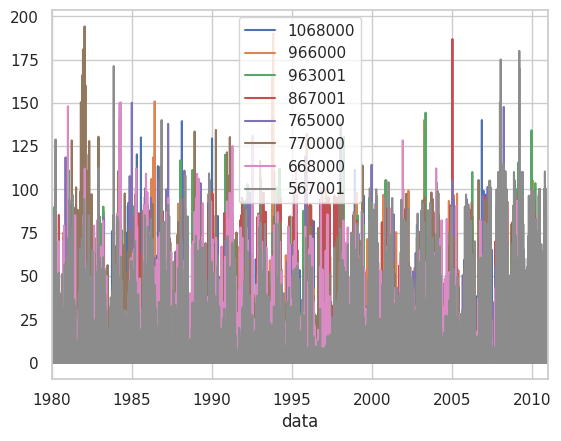

In [28]:
df_pluv.plot()

In [29]:
df_pluv.to_csv('prec_8_pluv_sem_falhas.csv')